# Gender Recognition by Voice
This dataset available from [Kaggle website](https://www.kaggle.com/primaryobjects/voicegender) was created to identify a voice as male or female, based upon acoustic properties of the voice and speech. The dataset consists of 3,168 recorded voice samples, collected from male and female speakers.
 The following acoustic properties of each voice are measured and included within the CSV:

* meanfreq: mean frequency (in kHz)
* sd: standard deviation of frequency
* median: median frequency (in kHz)
* Q25: first quantile (in kHz)
* Q75: third quantile (in kHz)
* IQR: interquantile range (in kHz)
* skew: skewness (see note in specprop description)
* kurt: kurtosis (see note in specprop description)
* sp.ent: spectral entropy
* sfm: spectral flatness
* mode: mode frequency
* centroid: frequency centroid (see specprop)
* peakf: peak frequency (frequency with highest energy)
* meanfun: average of fundamental frequency measured across acoustic signal
* minfun: minimum fundamental frequency measured across acoustic signal
* maxfun: maximum fundamental frequency measured across acoustic signal
* meandom: average of dominant frequency measured across acoustic signal
* mindom: minimum of dominant frequency measured across acoustic signal
* maxdom: maximum of dominant frequency measured across acoustic signal
* dfrange: range of dominant frequency measured across acoustic signal
* modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range
* label: male or female


In [1]:
import sys
import os

from pyspark.sql.types import *
import pyspark.sql.functions as func

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator 
from pyspark.ml.feature import Bucketizer, VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
file_name = 'voice.csv'

voice_data = sqlContext.read.csv(
                    os.path.join(file_name),
                    header=True, 
                    inferSchema=True)\
             .withColumnRenamed('sp.ent', 'sp_ent')\
             .cache()

## Dataset checks

The dataset is prepared for consumption already, even though it is very important to check it against unbalanced data. A dataset with unbalanced data is quite common in real life, and can cause lots of headhackes when not handled properly.

In [3]:
voice_data.groupBy('label').count().show()

+------+-----+
| label|count|
+------+-----+
|female| 1584|
|  male| 1584|
+------+-----+



We are luky! Our dataset has a perfect split across the two classes (male/female) we will try to predict with our classifier.

In [4]:
train, test = voice_data.randomSplit([0.8, 0.2], seed=42)
train.cache()
test.cache()

DataFrame[meanfreq: double, sd: double, median: double, Q25: double, Q75: double, IQR: double, skew: double, kurt: double, sp_ent: double, sfm: double, mode: double, centroid: double, meanfun: double, minfun: double, maxfun: double, meandom: double, mindom: double, maxdom: double, dfrange: double, modindx: double, label: string]

Let's seelct all the columns available beside out *label* column.

In [5]:
exclude_columns = ['label']
features_columns = [col for col in train.columns if col not in exclude_columns]

In [6]:
vectorAssembler = VectorAssembler(inputCols=features_columns, outputCol='features')
labelStringIndexer = StringIndexer(inputCol='label', outputCol='labelIndex')
logisticRegression = LogisticRegression(labelCol='labelIndex')

binaryClassEvaluator = BinaryClassificationEvaluator(labelCol='labelIndex')

pipeline = Pipeline(stages=[vectorAssembler, labelStringIndexer, logisticRegression])

paramGrid = ParamGridBuilder()\
            .addGrid(logisticRegression.regParam, [1.0, 0.1, 0.01])\
            .addGrid(logisticRegression.elasticNetParam, [0.0, 0.4, 0.8, 1.0])\
            .build()

crossValidator = CrossValidator(estimator=pipeline,
                                estimatorParamMaps=paramGrid,
                                evaluator=binaryClassEvaluator,
                                numFolds=5)

regressionModel = crossValidator.fit(train)

In [7]:
voice_data_predictions =  regressionModel.transform(test)

In [8]:
areaUnderROC = binaryClassEvaluator.evaluate(voice_data_predictions)

In [9]:
print "Area Under ROC: %f" % areaUnderROC

Area Under ROC: 0.989766


### Graph the 'Area Under the ROC Curve'
We will now plot the graph of the Area Under the ROC Curve, more details about the [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

In [10]:
probability_and_label = voice_data_predictions.select(['probability', 'labelIndex'])
 
## prepare score-label set
score_and_y = [(float(i[0][0]), 1.0-float(i[1])) for i in probability_and_label.collect()]


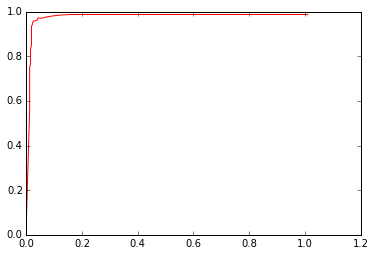

In [21]:
import numpy as np

score = [item[0] for item in score_and_y]
y = [item[1] for item in score_and_y]

roc_x = []
roc_y = []
min_score = min(score)
max_score = max(score)
thr = np.linspace(min_score, max_score, 30)
FP=0
TP=0
N = sum(y)
P = len(y) - N

for (i, T) in enumerate(thr):
    for i in range(0, len(score)):
        if (score[i] > T):
            if (y[i]==1):
                TP = TP + 1
            if (y[i]==0):
                FP = FP + 1
    roc_x.append(FP/float(N))
    roc_y.append(TP/float(P))
    FP=0
    TP=0

plt.plot(roc_x, roc_y,'r-')
plt.show()

**NOTE:** A better approach could be leveraging on [Scikit-Learn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) built-in functions.

In [12]:
multiclassEvaluator = MulticlassClassificationEvaluator(labelCol='labelIndex', metricName='accuracy')

logisticRegressionAccuracy = multiclassEvaluator.evaluate(voice_data_predictions)

In [13]:
print "Logistic Regression Accuracy: %f" % logisticRegressionAccuracy

Logistic Regression Accuracy: 0.965574


We already achieved a reasonably good accuracy on the test-set. Let's try some other algorithm and see if we can improve further

## Let's try a RandomForest

In [14]:
vectorAssembler = VectorAssembler(inputCols=features_columns, outputCol='features')

labelStringIndexer = StringIndexer(inputCol='label', outputCol='labelIndex')

randomForest = RandomForestClassifier(labelCol='labelIndex', maxDepth=20, seed=42)
binaryClassEvaluator = BinaryClassificationEvaluator(labelCol='labelIndex')

pipeline = Pipeline(stages=[vectorAssembler, labelStringIndexer, randomForest])

paramGrid = ParamGridBuilder()\
            .addGrid(randomForest.maxBins, [16, 32])\
            .addGrid(randomForest.numTrees, [5, 20])\
            .build()

crossValidator = CrossValidator(estimator=pipeline,
                                estimatorParamMaps=paramGrid,
                                evaluator=binaryClassEvaluator,
                                numFolds=5)

randomForestModel = crossValidator.fit(train)

In [15]:
voice_data_predictions_rf = randomForestModel.transform(test)

In [16]:
multiclassEvaluator.evaluate(voice_data_predictions_rf)

0.978688524590164